## LSTM class Developed
-----------------------------
[feat] 7/16
- ! to prevent overfitting use K-fold, validation split ! <- NEED TO DEVELOP
- basical LSTM model => lstm dense need to doubled
- not tested
- without AOC, interest rate
- bidirectional LSTM Model

[feat] 7/17

[need] 7/17
- val_loss 범위 설정
- k-fold 구현-> LSTM 구조상 폐기
- return값 설정
- 모델 예측 설정 방법


#### 7/19 V 1.0
[feat]
- postscale...      (done)
- model test res... (done)
- predict range .. (done) (using loss mean square err)

[need] 7/19 V 1.0
- prediction res return function => ??input??
-
[feat] V 1.0.1
- visiualization update
- check res (Request)

[feat] V 1.0.2
- loss calc func
- get tested output

#### 7/20
[feat & perf] V 1.1.0
- optimizated
- instanced model
- model complete

[need] V 1.1.0
- need to develop model quality
- sort & compedit gap values with prophet

if prophet is batter than LSTM use Prophet (by watching res)


imorts & get datas
------------

In [4]:
#!pip install -U finance-datareader

#%pip install FinanceDataReader

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
from time import sleep
#import FinanceDataReader as fdr

In [2]:
from google.colab import drive

drive.mount('/content/drive')

data=pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")

Mounted at /content/drive


In [42]:
# prescaler
def getAOC(data):
  AOC = []
  close = data['종가']
  close_pre = close.shift(1)

  AOC.append(0)

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(1, len(close)):
    aoc_value = ((close[i] - close_pre[i]) / close_pre[i]) * 100
    AOC.append(aoc_value)

  return AOC

#sort data by "종목명"
subject_Data=data.sort_values(by="종목코드",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

In [4]:
sliced_dataframes[0].columns[1:-1]

Index(['거래량', '고가', '시가', '저가'], dtype='object')

## LSTM Obj

In [22]:
class LSTM_Object():

  def __init__(self,data):
    #get sliced data
    self.data=data

  def modeling(self, num_batch = 128, num_dense = 32):

    self.prescale()
    self.model=Sequential()
    #layers
    self.model.add(Bidirectional(LSTM(1024,return_sequences=True,input_shape=(self.time_steps, self.num_features))))
    self.model.add(Dense(num_dense*16, activation='relu'))
    self.model.add(Dense(num_dense*8, activation='relu'))
    self.model.add(Dense(num_dense*4, activation='relu'))
    self.model.add(Dense(num_dense*2, activation='relu'))
    self.model.add(Dense(num_dense, activation='relu'))

    model_save_path='/content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests'

    #output layer
    self.model.add(Dense(1, activation='relu'))
    self.filename = join(model_save_path, 'ckeckpointer.ckpt')
    checkpoint = ModelCheckpoint(self.filename, save_weights_only=True, save_best_only=True,monitor='val_loss',verbose=0)

    earlystopping = EarlyStopping(monitor='val_loss', patience=100)
    self.model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.001))
    self.history=self.model.fit(self.x_train,self.y_train,epochs=1000,batch_size=num_batch,validation_data=(self.x_val,self.x_val),shuffle=False,callbacks=[checkpoint, earlystopping],verbose=0)

    return self.history


  def prescale(self):
    x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()
    # Scaling features
    x_data = self.data[self.data.columns[1:-1]]
    x_data = x_scaler.fit_transform(x_data)
    # Scaling target variable
    y_data = self.data['종가']
    y_data = self.y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    # validation set
    x_train_p, x_test, y_train_p, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.25, shuffle=False)
    __t,x_final,__t,__t=train_test_split(x_data, y_data, test_size=30/len(y_data), shuffle=False)

    ### reshape input datas()


    self.num_features = x_data.shape[1]
    self.num_samples=x_data.shape[0]
    self.time_steps=30

    self.x_train = self.create_sequences(x_train)
    self.x_test = self.create_sequences(x_test)
    self.x_val = self.create_sequences(x_val)
    self.x_final = self.create_sequences(x_final)

    self.y_train=self.create_sequences(y_train)
    self.y_test=self.create_sequences(y_test)
    self.y_val=self.create_sequences(y_val)



  def create_sequences(self, data):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)

  def inverse_sequences(self,data_sequences):
    num_samples, num_steps, num_features = data_sequences.shape
    data = np.zeros((num_samples + self.time_steps - 1, num_features))
    for i in range(num_samples):
      data[i:i + self.time_steps, :] += data_sequences[i, :, :]
    data /= self.time_steps
    return data[:num_samples]
    #frquency domain inverse laplace transform

  def ret_learning(self):
    # rescale to get real value
    self.modeling()
    sleep(0.5)
    self.model.load_weights(self.filename)
    pred = self.model.predict(self.x_test)
    sleep(0.5)
    rescaled_pred = self.y_scaler.inverse_transform(self.inverse_sequences(pred).reshape(-1,1))
    rescaled_real = self.y_scaler.inverse_transform(self.inverse_sequences(self.y_test).reshape(-1,1))
    sleep(0.5)

    #real-pred to get resonable value (later)
    k=0
    sum=0
    for p in rescaled_pred:
      sum+=abs(rescaled_real[k]-p)
      k+=1
    gap=sum/(k+1)

    #plt.figure(figsize=(12, 9))
    #plt.plot(rescaled_real, label='actual')
    #plt.plot(rescaled_pred, label='prediction')
    #plt.legend()
    #plt.show()

    return rescaled_pred,gap

  def predict_after_30days(self):
    _ , gap = self.ret_learning()
    self.model.load_weights(self.filename)
    pred_30 = self.model.predict(self.x_final)
    pred_30 = self.y_scaler.inverse_transform(self.inverse_sequences(pred_30).reshape(-1,1))
    pred_30=pred_30[-1]
    return pred_30,gap

  def model_evaluate(self):
    batch_size = [100, 200, 300, 500, 1000]
    dense_size = [8, 16, 32, 64, 128]

    train_loss_dict = {}
    val_loss_dict = {}

    for i in batch_size:
      for j in dense_size:
        print(f"Training for {i} batch size, {j} Dense...")
        history = self.modeling(num_batch = i, num_dense = j)
        key = f"{i} batch size, {j} dense"

        train_loss_dict[key] = history.history['loss']
        val_loss_dict[key] = history.history['val_loss']

    # 결과 그래프로 plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20))

    # 학습 손실 그래프
    for key, train_loss in train_loss_dict.items():
        ax1.plot(train_loss, label=f'Train - {key}')

    ax1.set_ylabel('Loss')
    ax1.set_title('Train Loss')
    ax1.legend()

    # 검증 손실 그래프
    for key, val_loss in val_loss_dict.items():
        ax2.plot(val_loss, label=f'Validation - {key}')

    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Validation Loss')
    ax2.legend()

    ax1.set_ylim(0, 0.2)
    ax2.set_ylim(0, 0.1)

    plt.tight_layout()  # 서브플롯 간 간격 조절
    plt.show()


labels sort

(위에서 종목명으로하던, 종목코드로 sort하던 아무 상관없음.
왜냐하면, 종목코드가 종목명 순서대로 부여되는거 같음.
-> 검증완료함)

In [44]:
labels=data[['종목코드']]
labels = labels.sort_values(by='종목코드')
labels.iloc[0]

종목코드    A000020
Name: 718502, dtype: object

Training for 100 batch size, 8 Dense...
Training for 100 batch size, 16 Dense...
Training for 100 batch size, 32 Dense...
Training for 100 batch size, 64 Dense...
Training for 100 batch size, 128 Dense...
Training for 200 batch size, 8 Dense...
Training for 200 batch size, 16 Dense...
Training for 200 batch size, 32 Dense...
Training for 200 batch size, 64 Dense...
Training for 200 batch size, 128 Dense...
Training for 300 batch size, 8 Dense...
Training for 300 batch size, 16 Dense...
Training for 300 batch size, 32 Dense...
Training for 300 batch size, 64 Dense...
Training for 300 batch size, 128 Dense...
Training for 500 batch size, 8 Dense...
Training for 500 batch size, 16 Dense...
Training for 500 batch size, 32 Dense...
Training for 500 batch size, 64 Dense...
Training for 500 batch size, 128 Dense...
Training for 1000 batch size, 8 Dense...
Training for 1000 batch size, 16 Dense...
Training for 1000 batch size, 32 Dense...
Training for 1000 batch size, 64 Dense...
Training for 

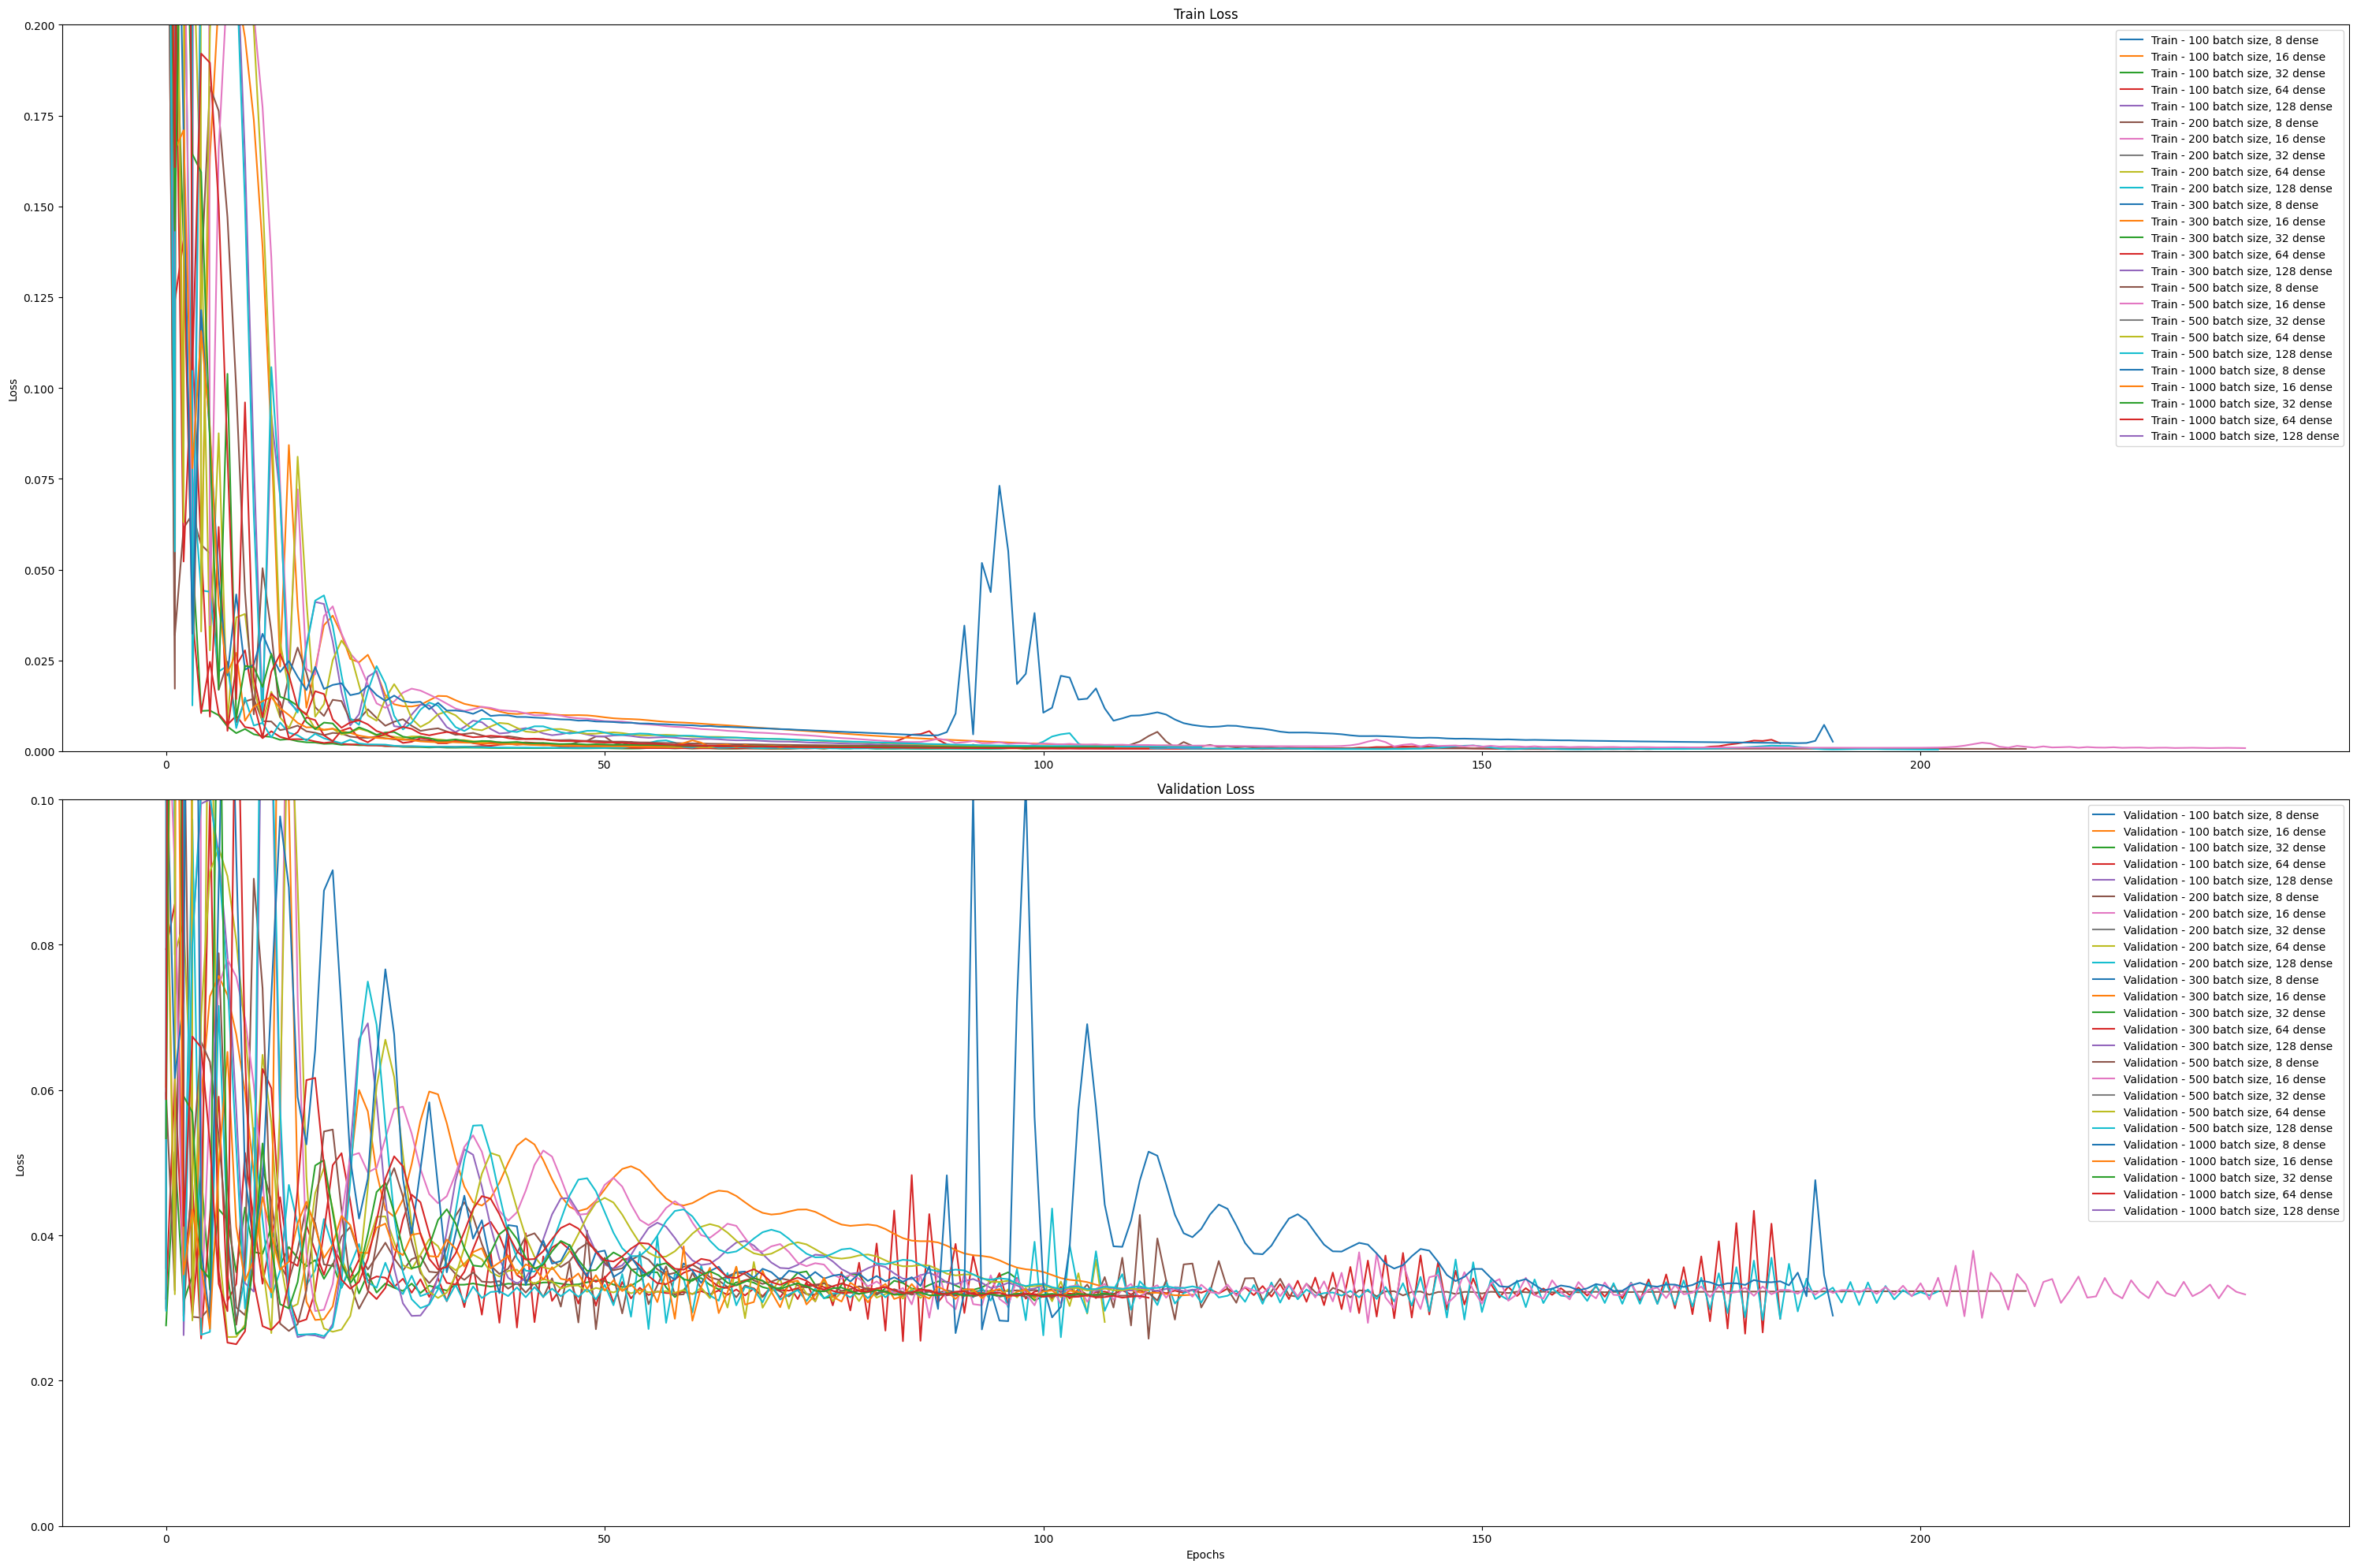

In [23]:
LSTM_model = LSTM_Object(sliced_dataframes[5])
LSTM_model.model_evaluate()

test shell

In [25]:
pred_list=[]
gap_acc=[]

test=sliced_dataframes[0]
print(labels.iloc[0])
#결과랑 실제 값이랑 같게 나오도록 코드 수정해줘 -민 // 슬라이스 내가 한거 아니라서 입력되는 순서가 종목 코드별로 sort되어있는지 확인 필요할듯
#무튼 입력값이랑 프린트에 나오는 종목코드랑 같은애면 됨
LSTM_model=LSTM_Object(test)

pred,gap = LSTM_model.predict_after_30days()

pred

종목코드    A060310
Name: 0, dtype: object
1/1 [==============================] - 0s 29ms/step


array([8185.64374147])

In [ ]:
idx=0

pred_list=[]
gap_acc=[]
out_labels=[]
for c in sliced_dataframes:
  print(labels.iloc[idx])     #결과랑 실제 값이랑 같게 나오도록 코드 수정해줘 -민 // 슬라이스 내가 한거 아니라 수정하기 싫..
  LSTM_model=LSTM_Object(c)
  pred,gap = LSTM_model.ret_learning()
  idx+=1
  out_labels.append(labels.iloc[idx])
  sleep(2)
  pred_list.append(pred)
  gap_acc.append(gap)
  #to prevent model corrupting

종목코드    A060310
Name: 0, dtype: object
3/3 [==============================] - 3s 448ms/step
종목코드    A095570
Name: 1, dtype: object
3/3 [==============================] - 2s 443ms/step
종목코드    A006840
Name: 2, dtype: object
3/3 [==============================] - 3s 474ms/step
종목코드    A054620
Name: 3, dtype: object


3/3 [==============================] - 3s 487ms/step
종목코드    A265520
Name: 4, dtype: object


3/3 [==============================] - 4s 827ms/step
종목코드    A211270
Name: 5, dtype: object
3/3 [==============================] - 3s 478ms/step
종목코드    A027410
Name: 6, dtype: object
3/3 [==============================] - 2s 394ms/step
종목코드    A282330
Name: 7, dtype: object
3/3 [==============================] - 2s 395ms/step
종목코드    A126600
Name: 8, dtype: object
3/3 [==============================] - 3s 505ms/step
종목코드    A138930
Name: 9, dtype: object
3/3 [==============================] - 3s 496ms/step
종목코드    A001460
Name: 10, dtype: object
3/3 [==============================] - 3s 433ms/step
종목코드    A013720
Name: 11, dtype: object
3/3 [==============================] - 2s 463ms/step
종목코드    A001040
Name: 12, dtype: object
3/3 [==============================] - 3s 428ms/step
종목코드    A079160
Name: 13, dtype: object
3/3 [==============================] - 3s 467ms/step
종목코드    A035760
Name: 14, dtype: object
3/3 [==============================] - 3s 615ms/step
종목코드    A311690
Name: 

AttributeError: ignored

###  output code

In [ ]:
df=pd.dataframe(
    {
        '종목코드': out_labels,
        '종가': pred_list
    }
)

df.sort_values(by='종가')
df_out=df[['종목코드']]
df_out.to_csv('/content/drive/MyDrive/2023_1st_vac/KRX_modelings/csv_outputs',index=True)

In [ ]:
labels.iloc[0]